# model.ipynb: 示例代码，建立决策树
这是示例代码，目的是为了让您更好地了解我们的算法。

方便起见，本notebook中只用了一个训练集，即`final-2.h5`。如果要使用全部的训练集，请参见`train.ipynb`。

为了能够更加清晰地展现出数据的处理过程，这里不用先跑预处理数据的代码`waveform.py`，而会将对数据的预处理放在代码块中。

本notebook的任务是训练出决策树，目标是每个事件的动量p，即`modelPCalc.txt`。

训练完之后，运行`final.ipynb`，便可以得到最终的答案。

可以将建立决策树的过程分为以下几步：
1. 读取训练集；
2. 对波形进行除噪声处理；
3. 使用波形，找到每个波形对应的PE总数，以及PETime平均值；
4. 每个事件都有很多波形，这些波形都有各自对应的PE总数和PETime平均值。对这些数据，按照事件做如下处理：
    - PE总数对每个事件求和；
    - PE总数对每个事件求平均值；
    - PE总数对每个事件求标准差；
    - PETime平均值对每个事件求平均值；
    - PETime平均值对每个事件求标准差；
5. 使用4中得到的5个特征，训练到动量`p`的决策树。

下面也按照这五步的顺序，展示相应的代码。

In [1]:
import multiprocessing
import warnings # 临时需要，没有的话有一步代码会疯狂报/0的warning，其实这是正常情况
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from utils import loadData, getNum, getPePerWF, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包
# %load_ext line_profiler

## 1. 读取训练集

先指定训练集的位置`trainPath`，本示例代码中只使用了一个数据集`final-2.h5`。git仓库中并没有数据集，需要先跑`fetch.sh`，或者执行`make data`。

所有的文件读取操作均由`utils.py`中的`loadData`函数实现。

读取训练集可能需要一分钟左右。结束后会展示读进来的三个表的信息。

In [2]:
trainPath = "./data/final-2.h5" # 指定训练集位置

# %lprun -f loadData loadData(trainPath, 'PT')

# trainPET是PETruth表，trainWF是Waveform表，trainPT是ParticleTruth表
trainPET, trainWF, trainPT = loadData(trainPath, 'PT')

  0%|          | 0/16 [00:00<?, ?it/s]

正在读取data


100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


## 2. 对波形进行去噪声处理
设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声，置为0。

这里波形的数据是反过来的，因此再用918去减有意义的信息，得到去噪之后的波形。

这可以去除绝大部分没有PE处的暗噪声，但有PE处的暗噪声不能被去除。

In [3]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

## 3. 使用波形，找到每个波形对应的PE总数，以及PETime平均值

这里使用了手作算法，`getPePerWF`函数。函数的具体实现位于`utils.py`中。算法的大致思路如下（下面的“波形”均指去噪后的波形）：
1. 将PE总数置为0，将PETime总数置为0。如果一个波形，纵坐标超过0的点的数量小于4，则不进行2-7；
2. 对一个波形，执行`np.argmax`，找到最大值对应的index后，认为这是一次PE所在的位置；
3. 将波形减去一个峰值在argmax处的取消函数（表示一个PE产生的效果），这里简单地取峰值是18，宽度是16的三角单脉冲波；
4. 对一个波形，在历史上取过的所有取消函数不为0的区域，判断纵坐标是否小于8，如果是则认为是噪声造成的，置为0；
5. 计算减去后的波形的积分，以及纵坐标超过0的点的数量；
6. 如果$150 \leq \text{argmax} \leq 600$，则PE总数+1，PETime总数+argmax;
7. 重复2-6的操作，直到波形的积分小于$150-8\text{max}\{\text{超过0的点数量}, 16-\text{超过0的点数量}\}$；
8. 返回PE总数，以及PETime总数/PE总数

手作算法中使用了波形积分以及纵坐标超过0的点的数量。我们可以通过下面的代码获取这两个值：

In [4]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)

为了检验手作算法的效果，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值。这里需要将EventID与ChannelID相同的行并列起来。但由于有暗触发的问题，又需要把没有PE的波形单独找出来。

为了方便以后的实现，我们先将属于一个Event的PE分开。这里调用了`utils.py`中定义的`getNum`函数。得到的`peIndices`是一个$(n+1,)$的ndarray，$n$表示训练集的EventID数。当$i<n$时，`peIndices[i]`表示EventID为$i$对应第一个PE的下标；当$i=n$时，`peIndices[i]`表示训练集PETruth表的总行数。`wfIndices`是类似的。

为什么要$n+1$呢？~历史上是因为这样能更方便地得到`numPET`~因为如果需要将18个训练集拼接成一个训练集，就会方便很多。详见`train.ipynb`。

`numPET`与`numPEW`是$(n,)$的ndarray，下标为$i$各表示EventID为$i$时的PE数和波形数。这两个变量后面并没有用到，因为历史原因保留在这里。

In [5]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

在这之后，将同一事件的waveform和PETruth分开，分别按照ChannelID进行`np.unique`，我们便可以得到`pePerTrainWF`了。

In [6]:
pePerTrainWF = np.array([], dtype=int)
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    
    # 上面得到的counts并不能直接用，因为需要为暗触发的waveform补0

    # 使用isin得到counts虽然很简洁，但似乎略慢于傻傻地使用while，原因不明。
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0) #注意不能一次性insert了，要用for循环，因为可能会越界访问。

    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:16<00:00, 120.36it/s]


下面检验手作算法的效果。这里的代码会随机在训练集中取两个波形，让`getPePerWF`进行分析，并且打印出结果，波形对应的积分，超过0的点数量，正确的`pePerTrainWF`，以及画出波形的图像。

PE真值是[1 1]
积分是[105  73]
超出阈值的点是[18 17]
手作算法返回值为[[  1.   1.]
 [353. 228.]]


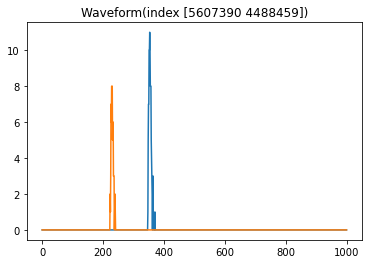

In [7]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1,2) # 随机取两个波形
# %lprun -f getPePerWF getPePerWF(denoisedTrainWF[randIndex])
res = getPePerWF(denoisedTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"手作算法返回值为{res}")
plt.plot(denoisedTrainWF[randIndex][0])
plt.plot(denoisedTrainWF[randIndex][1])
plt.title(f"Waveform(index {randIndex})")
plt.show()

这是正式处理训练集的代码。

注意，如果没有`warnings.simplefilter("ignore")`，会导致疯狂报0/0的warning。这是由于一个waveform可能全是暗噪声，或者根本就是暗触发，导致手作算法根本没有运行argmax（这也是正确的表现）。后面的代码会处理nan，所以这里忽略warning。

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    chunkNum = 100
    splitDenoisedTrainWF = np.array_split(denoisedTrainWF, chunkNum)
    with multiprocessing.Pool(8) as pool:
        res = np.concatenate(list(tqdm(
                                pool.imap(
                                    getPePerWF,
                                    splitDenoisedTrainWF
                                ),
                                total=chunkNum
                                )),
                            axis=1)
        pePerTrainWFCalc, meanPeTimePerTrainWF = res

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


下面检验`pePerTranWFCalc`与真正的`pePerTrainWF`的关系，画出散点图。

可以看到，两者大致在一直线上，斜率略大于1。

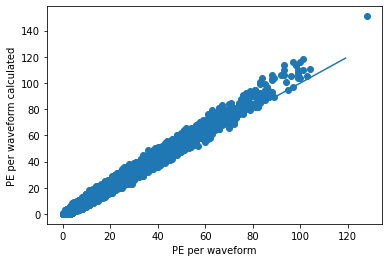

In [9]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform calculated")
plt.plot(np.arange(120), np.arange(120))
plt.show()

## 4. 对PE总数与PETime平均值，按照事件进行处理
目标是以下五个值：
- PE总数对每个事件求和；
- PE总数对每个事件求平均值；
- PE总数对每个事件求标准差；
- PETime平均值对每个事件求平均值；
- PETime平均值对每个事件求标准差；

将属于不同事件的`pePerTrainWFFinal`分开，然后得到这五个feature。

除此之外，从`trainPT`中读取目标`p`

In [10]:
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
p = trainPT['p']
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1])
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)


100%|██████████| 2000/2000 [00:00<00:00, 5381.23it/s]


## 5. 使用4中得到的5个特征，训练到动量`p`的决策树。
使用`lightgbm`，先创造训练集与验证集，使用后200个数据作为验证集，之前的数据作为训练集；然后按照参数训练决策树，存储到`./model/modelPCalc.txt`中。

In [11]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-200], peMean[:-200], peStd[:-200], peTimeMean[:-200], peTimeStd[:-200]),
        axis=1
    ),
    label=p[:-200]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-200:], peMean[-200:], peStd[-200:], peTimeMean[-200:], peTimeStd[-200:]),
        axis=1
    ),
    label=p[-200:],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'custom'},
    'num_leaves': 2**10,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=1000,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('./model/modelPCalc.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's custom: 5.34361
Training until validation scores don't improve for 1000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's custom: 5.23735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's custom: 5.13305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's custom: 5.03096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's custom: 4.93081
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's custom: 0.710396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's custom: 0.696458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's custom: 0.682771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's custom: 0.669368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's custom: 0.65628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's custom: 0.643374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's custom: 0.630766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's custom: 0.618387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's custom: 0.606257
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's custom: 0.0617421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's custom: 0.0607131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's custom: 0.0596987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's custom: 0.058695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's custom: 0.057733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's custom: 0.0567699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's custom: 0.0558467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's custom: 0.0549413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's custom: 0.054032
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[363]	valid_0's custom: 0.013907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[364]	valid_0's custom: 0.013844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[365]	valid_0's custom: 0.0137827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's custom: 0.013722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's custom: 0.0136599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's custom: 0.0136023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's custom: 0.013547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's custom: 0.0134832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's custom: 0.0134313
[LightGBM] [Warning] No

[513]	valid_0's custom: 0.0107256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's custom: 0.0107189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's custom: 0.0107209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's custom: 0.0107126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's custom: 0.010706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's custom: 0.0107007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's custom: 0.0106947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's custom: 0.0106949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's custom: 0.0106875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's cust

[608]	valid_0's custom: 0.0104696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's custom: 0.0104592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's custom: 0.0104523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's custom: 0.0104501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's custom: 0.0104528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's custom: 0.0104425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's custom: 0.0104333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's custom: 0.0104307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's custom: 0.0104323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's cus

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	valid_0's custom: 0.0101593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's custom: 0.0101552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	valid_0's custom: 0.0101479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[711]	valid_0's custom: 0.0101444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[712]	valid_0's custom: 0.0101423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[713]	valid_0's custom: 0.0101342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[714]	valid_0's custom: 0.0101296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[715]	valid_0's custom: 0.0101311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[716]	valid_0's custom: 0.0101279
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's custom: 0.0100243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's custom: 0.0100249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's custom: 0.0100226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's custom: 0.0100236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's custom: 0.0100246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's custom: 0.0100252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's custom: 0.0100269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's custom: 0.0100278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's custom: 0.0100288
[LightGBM] [Warning

[926]	valid_0's custom: 0.00988844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's custom: 0.0098884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's custom: 0.00988689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's custom: 0.00988675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's custom: 0.0098877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[931]	valid_0's custom: 0.00988351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[932]	valid_0's custom: 0.00987748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[933]	valid_0's custom: 0.0098782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[934]	valid_0's custom: 0.00987955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[935]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1028]	valid_0's custom: 0.00970867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1029]	valid_0's custom: 0.00970866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1030]	valid_0's custom: 0.0097019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1031]	valid_0's custom: 0.00970163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's custom: 0.00970414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's custom: 0.00970215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's custom: 0.00970497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's custom: 0.00969866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's custom: 0.00969109
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's custom: 0.0094714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's custom: 0.00946791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's custom: 0.00946402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's custom: 0.00946354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's custom: 0.00945963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1131]	valid_0's custom: 0.00946182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1132]	valid_0's custom: 0.0094558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1133]	valid_0's custom: 0.00945757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1134]	valid_0's custom: 0.00946009
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's custom: 0.00937635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's custom: 0.0093743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's custom: 0.00937342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1214]	valid_0's custom: 0.00936958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1215]	valid_0's custom: 0.00936596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1216]	valid_0's custom: 0.00936707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1217]	valid_0's custom: 0.00936096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1218]	valid_0's custom: 0.0093615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1219]	valid_0's custom: 0.00935749
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's custom: 0.00919641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's custom: 0.00919726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's custom: 0.00919255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's custom: 0.00919277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1301]	valid_0's custom: 0.00918777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1302]	valid_0's custom: 0.009189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's custom: 0.00918548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's custom: 0.00918587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's custom: 0.0091846
[Lig

[1407]	valid_0's custom: 0.00908137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's custom: 0.00908338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's custom: 0.00908257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's custom: 0.00907842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's custom: 0.00907668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's custom: 0.00907425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's custom: 0.00907055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's custom: 0.00906701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	valid_0's custom: 0.00906741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's custom: 0.00891946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's custom: 0.00892052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1527]	valid_0's custom: 0.00891882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1528]	valid_0's custom: 0.00891688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1529]	valid_0's custom: 0.00891783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1530]	valid_0's custom: 0.0089161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1531]	valid_0's custom: 0.00891546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1532]	valid_0's custom: 0.00891263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1533]	valid_0's custom: 0.00890867
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1636]	valid_0's custom: 0.00876745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1637]	valid_0's custom: 0.00876755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1638]	valid_0's custom: 0.00876573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1639]	valid_0's custom: 0.00876258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1640]	valid_0's custom: 0.0087625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1641]	valid_0's custom: 0.00876164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1642]	valid_0's custom: 0.00875855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1643]	valid_0's custom: 0.0087606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1644]	valid_0's custom: 0.00875714
[Li

[1747]	valid_0's custom: 0.0086078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1748]	valid_0's custom: 0.00860921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's custom: 0.00860713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's custom: 0.00860506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's custom: 0.0086035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's custom: 0.00860342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's custom: 0.00860009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1754]	valid_0's custom: 0.00859806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1755]	valid_0's custom: 0.00859637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1836]	valid_0's custom: 0.00851899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1837]	valid_0's custom: 0.00852001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1838]	valid_0's custom: 0.00851872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1839]	valid_0's custom: 0.00851565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1840]	valid_0's custom: 0.00851341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1841]	valid_0's custom: 0.00851307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1842]	valid_0's custom: 0.00851158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1843]	valid_0's custom: 0.00851204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1844]	valid_0's custom: 0.00851047
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1933]	valid_0's custom: 0.0084145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1934]	valid_0's custom: 0.00841262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's custom: 0.00840944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's custom: 0.00840648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's custom: 0.00840649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's custom: 0.00840715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's custom: 0.00840778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's custom: 0.0084064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's custom: 0.00840638
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2025]	valid_0's custom: 0.00835832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2026]	valid_0's custom: 0.00835715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2027]	valid_0's custom: 0.00835594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2028]	valid_0's custom: 0.00835431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2029]	valid_0's custom: 0.00835152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2030]	valid_0's custom: 0.00835061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2031]	valid_0's custom: 0.00835069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2032]	valid_0's custom: 0.00835103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2033]	valid_0's custom: 0.00835039
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2120]	valid_0's custom: 0.00830863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2121]	valid_0's custom: 0.00830805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2122]	valid_0's custom: 0.00830695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2123]	valid_0's custom: 0.00830552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2124]	valid_0's custom: 0.00830482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2125]	valid_0's custom: 0.00830479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2126]	valid_0's custom: 0.0083051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2127]	valid_0's custom: 0.00830482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2128]	valid_0's custom: 0.00830532
[L

[2217]	valid_0's custom: 0.00828504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2218]	valid_0's custom: 0.0082835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2219]	valid_0's custom: 0.00828465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2220]	valid_0's custom: 0.00828466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2221]	valid_0's custom: 0.00828446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2222]	valid_0's custom: 0.00828511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2223]	valid_0's custom: 0.00828201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2224]	valid_0's custom: 0.00828185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2225]	valid_0's custom: 0.00828126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2330]	valid_0's custom: 0.00822556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2331]	valid_0's custom: 0.00822405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2332]	valid_0's custom: 0.0082228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2333]	valid_0's custom: 0.00822233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2334]	valid_0's custom: 0.00822328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2335]	valid_0's custom: 0.0082243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2336]	valid_0's custom: 0.00822374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2337]	valid_0's custom: 0.00822329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2338]	valid_0's custom: 0.00822524
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2414]	valid_0's custom: 0.00819944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2415]	valid_0's custom: 0.00819979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's custom: 0.00819935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2417]	valid_0's custom: 0.00819769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2418]	valid_0's custom: 0.00819785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2419]	valid_0's custom: 0.00819891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2420]	valid_0's custom: 0.00819822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2421]	valid_0's custom: 0.00819883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2422]	valid_0's custom: 0.00819955
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2513]	valid_0's custom: 0.0082076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2514]	valid_0's custom: 0.00820648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2515]	valid_0's custom: 0.00820714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2516]	valid_0's custom: 0.00820491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2517]	valid_0's custom: 0.00820198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2518]	valid_0's custom: 0.00820127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2519]	valid_0's custom: 0.00820138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2520]	valid_0's custom: 0.00819853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2521]	valid_0's custom: 0.00819942
[L

[2607]	valid_0's custom: 0.00817377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2608]	valid_0's custom: 0.00817492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2609]	valid_0's custom: 0.00817507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2610]	valid_0's custom: 0.00817509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2611]	valid_0's custom: 0.00817417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2612]	valid_0's custom: 0.00817138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2613]	valid_0's custom: 0.0081691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2614]	valid_0's custom: 0.00816851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2615]	valid_0's custom: 0.00816611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

[2774]	valid_0's custom: 0.00811747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2775]	valid_0's custom: 0.00811554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2776]	valid_0's custom: 0.00811355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2777]	valid_0's custom: 0.00811519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2778]	valid_0's custom: 0.00811597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2779]	valid_0's custom: 0.00811539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2780]	valid_0's custom: 0.00811499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2781]	valid_0's custom: 0.00811545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2782]	valid_0's custom: 0.00811515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2884]	valid_0's custom: 0.00808263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2885]	valid_0's custom: 0.00808213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2886]	valid_0's custom: 0.00808138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2887]	valid_0's custom: 0.00808067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2888]	valid_0's custom: 0.00808024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2889]	valid_0's custom: 0.00808039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2890]	valid_0's custom: 0.00808044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2891]	valid_0's custom: 0.00807947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2892]	valid_0's custom: 0.00808016
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2986]	valid_0's custom: 0.00805567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2987]	valid_0's custom: 0.0080558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2988]	valid_0's custom: 0.00805618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2989]	valid_0's custom: 0.00805304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2990]	valid_0's custom: 0.00805266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2991]	valid_0's custom: 0.00805151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2992]	valid_0's custom: 0.00805056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2993]	valid_0's custom: 0.00805071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2994]	valid_0's custom: 0.00804951
[L

[3078]	valid_0's custom: 0.00802301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3079]	valid_0's custom: 0.00802309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3080]	valid_0's custom: 0.00802344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3081]	valid_0's custom: 0.00802331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3082]	valid_0's custom: 0.00802307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3083]	valid_0's custom: 0.00802275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3084]	valid_0's custom: 0.00802272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3085]	valid_0's custom: 0.00802143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3086]	valid_0's custom: 0.00802178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3170]	valid_0's custom: 0.00801675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3171]	valid_0's custom: 0.00801704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3172]	valid_0's custom: 0.00801765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3173]	valid_0's custom: 0.00801724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3174]	valid_0's custom: 0.00801783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3175]	valid_0's custom: 0.00801915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3176]	valid_0's custom: 0.00801977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3177]	valid_0's custom: 0.00801914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3178]	valid_0's custom: 0.00801851
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3258]	valid_0's custom: 0.00801022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3259]	valid_0's custom: 0.00801061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3260]	valid_0's custom: 0.00801059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3261]	valid_0's custom: 0.00801025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3262]	valid_0's custom: 0.00800992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3263]	valid_0's custom: 0.00801032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3264]	valid_0's custom: 0.00801116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3265]	valid_0's custom: 0.00801104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3266]	valid_0's custom: 0.0080094
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3349]	valid_0's custom: 0.00800228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3350]	valid_0's custom: 0.00800104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3351]	valid_0's custom: 0.00800072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3352]	valid_0's custom: 0.00800038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3353]	valid_0's custom: 0.00799981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3354]	valid_0's custom: 0.00799928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3355]	valid_0's custom: 0.00799921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3356]	valid_0's custom: 0.00799899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3357]	valid_0's custom: 0.00799824
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3447]	valid_0's custom: 0.00798252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3448]	valid_0's custom: 0.00798214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3449]	valid_0's custom: 0.00798099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3450]	valid_0's custom: 0.00798007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3451]	valid_0's custom: 0.00797976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3452]	valid_0's custom: 0.00797875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3453]	valid_0's custom: 0.00797854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3454]	valid_0's custom: 0.00797748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3455]	valid_0's custom: 0.00797818
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3533]	valid_0's custom: 0.00797779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3534]	valid_0's custom: 0.00797802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3535]	valid_0's custom: 0.00797842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3536]	valid_0's custom: 0.0079788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3537]	valid_0's custom: 0.00797824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3538]	valid_0's custom: 0.00797802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3539]	valid_0's custom: 0.00797864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3540]	valid_0's custom: 0.00797877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3541]	valid_0's custom: 0.00797949
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3620]	valid_0's custom: 0.00798038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3621]	valid_0's custom: 0.00797983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3622]	valid_0's custom: 0.00798057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3623]	valid_0's custom: 0.00797882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3624]	valid_0's custom: 0.00797678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3625]	valid_0's custom: 0.00797639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3626]	valid_0's custom: 0.00797573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3627]	valid_0's custom: 0.00797486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3628]	valid_0's custom: 0.00797471
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3709]	valid_0's custom: 0.00796051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3710]	valid_0's custom: 0.0079594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3711]	valid_0's custom: 0.00795935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3712]	valid_0's custom: 0.00795927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3713]	valid_0's custom: 0.00795946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3714]	valid_0's custom: 0.00795794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3715]	valid_0's custom: 0.00795642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3716]	valid_0's custom: 0.00795627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3717]	valid_0's custom: 0.00795626
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3784]	valid_0's custom: 0.00794839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3785]	valid_0's custom: 0.0079493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3786]	valid_0's custom: 0.0079495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3787]	valid_0's custom: 0.00794922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3788]	valid_0's custom: 0.00794815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3789]	valid_0's custom: 0.00794809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3790]	valid_0's custom: 0.00794824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3791]	valid_0's custom: 0.00794814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3792]	valid_0's custom: 0.00794871
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3878]	valid_0's custom: 0.00795133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3879]	valid_0's custom: 0.00795116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3880]	valid_0's custom: 0.00795004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3881]	valid_0's custom: 0.00794936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3882]	valid_0's custom: 0.00794844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3883]	valid_0's custom: 0.00794805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3884]	valid_0's custom: 0.00794821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3885]	valid_0's custom: 0.007949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3886]	valid_0's custom: 0.00794871
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3962]	valid_0's custom: 0.00794384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3963]	valid_0's custom: 0.00794275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3964]	valid_0's custom: 0.00794393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3965]	valid_0's custom: 0.00794417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3966]	valid_0's custom: 0.00794462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3967]	valid_0's custom: 0.00794527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3968]	valid_0's custom: 0.00794539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3969]	valid_0's custom: 0.00794619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3970]	valid_0's custom: 0.00794655
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4053]	valid_0's custom: 0.00795224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4054]	valid_0's custom: 0.00795206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4055]	valid_0's custom: 0.0079514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4056]	valid_0's custom: 0.0079517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4057]	valid_0's custom: 0.00795209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4058]	valid_0's custom: 0.00795197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4059]	valid_0's custom: 0.00795179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4060]	valid_0's custom: 0.00795105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4061]	valid_0's custom: 0.00795062
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4139]	valid_0's custom: 0.00794225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4140]	valid_0's custom: 0.00794258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4141]	valid_0's custom: 0.00794262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4142]	valid_0's custom: 0.00794263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4143]	valid_0's custom: 0.00794311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4144]	valid_0's custom: 0.00794236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4145]	valid_0's custom: 0.00794284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4146]	valid_0's custom: 0.00794285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4147]	valid_0's custom: 0.00794313
[

[4232]	valid_0's custom: 0.00795686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4233]	valid_0's custom: 0.00795679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4234]	valid_0's custom: 0.00795645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4235]	valid_0's custom: 0.00795669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4236]	valid_0's custom: 0.00795663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4237]	valid_0's custom: 0.00795522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4238]	valid_0's custom: 0.00795479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4239]	valid_0's custom: 0.00795547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4240]	valid_0's custom: 0.00795615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4313]	valid_0's custom: 0.00794833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4314]	valid_0's custom: 0.00794806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4315]	valid_0's custom: 0.00794818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4316]	valid_0's custom: 0.00794886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4317]	valid_0's custom: 0.00794956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4318]	valid_0's custom: 0.00795018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4319]	valid_0's custom: 0.00794951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4320]	valid_0's custom: 0.00794964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4321]	valid_0's custom: 0.0079497
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4405]	valid_0's custom: 0.00794105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4406]	valid_0's custom: 0.00794079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4407]	valid_0's custom: 0.00794069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4408]	valid_0's custom: 0.0079405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4409]	valid_0's custom: 0.00794098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4410]	valid_0's custom: 0.00794072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4411]	valid_0's custom: 0.00794115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4412]	valid_0's custom: 0.00794138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4413]	valid_0's custom: 0.00794173
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4488]	valid_0's custom: 0.00794521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4489]	valid_0's custom: 0.00794537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4490]	valid_0's custom: 0.00794511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4491]	valid_0's custom: 0.00794533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4492]	valid_0's custom: 0.00794465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4493]	valid_0's custom: 0.00794398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4494]	valid_0's custom: 0.0079433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4495]	valid_0's custom: 0.00794321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4496]	valid_0's custom: 0.00794244
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4586]	valid_0's custom: 0.00793931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4587]	valid_0's custom: 0.00793958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4588]	valid_0's custom: 0.00793921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4589]	valid_0's custom: 0.00793918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4590]	valid_0's custom: 0.00793997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4591]	valid_0's custom: 0.00793974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4592]	valid_0's custom: 0.0079388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4593]	valid_0's custom: 0.00793845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4594]	valid_0's custom: 0.00793828
[L

[4679]	valid_0's custom: 0.00793407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4680]	valid_0's custom: 0.00793352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4681]	valid_0's custom: 0.00793463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4682]	valid_0's custom: 0.0079348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4683]	valid_0's custom: 0.00793531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4684]	valid_0's custom: 0.00793466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4685]	valid_0's custom: 0.00793512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4686]	valid_0's custom: 0.00793527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4687]	valid_0's custom: 0.00793474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4782]	valid_0's custom: 0.00793866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4783]	valid_0's custom: 0.00793878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4784]	valid_0's custom: 0.00793939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4785]	valid_0's custom: 0.00793964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4786]	valid_0's custom: 0.00793954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4787]	valid_0's custom: 0.00794023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4788]	valid_0's custom: 0.00794029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4789]	valid_0's custom: 0.00794038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4790]	valid_0's custom: 0.00794082
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4872]	valid_0's custom: 0.00793648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4873]	valid_0's custom: 0.00793563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4874]	valid_0's custom: 0.00793436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4875]	valid_0's custom: 0.00793438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4876]	valid_0's custom: 0.00793451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4877]	valid_0's custom: 0.00793508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4878]	valid_0's custom: 0.00793539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4879]	valid_0's custom: 0.00793485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4880]	valid_0's custom: 0.00793513
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4957]	valid_0's custom: 0.00793955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4958]	valid_0's custom: 0.00794028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4959]	valid_0's custom: 0.00794072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4960]	valid_0's custom: 0.00794074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4961]	valid_0's custom: 0.00794116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4962]	valid_0's custom: 0.00794052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4963]	valid_0's custom: 0.00793965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4964]	valid_0's custom: 0.00793958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4965]	valid_0's custom: 0.00794008
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5043]	valid_0's custom: 0.00793341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5044]	valid_0's custom: 0.00793342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5045]	valid_0's custom: 0.00793351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5046]	valid_0's custom: 0.00793356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5047]	valid_0's custom: 0.00793334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5048]	valid_0's custom: 0.0079336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5049]	valid_0's custom: 0.00793293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5050]	valid_0's custom: 0.00793299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5051]	valid_0's custom: 0.00793303
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5137]	valid_0's custom: 0.00793877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5138]	valid_0's custom: 0.0079386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5139]	valid_0's custom: 0.00793828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5140]	valid_0's custom: 0.00793862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5141]	valid_0's custom: 0.00793931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5142]	valid_0's custom: 0.0079393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5143]	valid_0's custom: 0.00793974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5144]	valid_0's custom: 0.00793991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5145]	valid_0's custom: 0.0079408
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5215]	valid_0's custom: 0.00792818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5216]	valid_0's custom: 0.00792829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5217]	valid_0's custom: 0.00792785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5218]	valid_0's custom: 0.00792767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5219]	valid_0's custom: 0.00792798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5220]	valid_0's custom: 0.00792791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5221]	valid_0's custom: 0.00792847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5222]	valid_0's custom: 0.00792865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5223]	valid_0's custom: 0.00792879
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5313]	valid_0's custom: 0.00792163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5314]	valid_0's custom: 0.00792151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5315]	valid_0's custom: 0.00792108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5316]	valid_0's custom: 0.00792034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5317]	valid_0's custom: 0.00792059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5318]	valid_0's custom: 0.0079216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5319]	valid_0's custom: 0.00792119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5320]	valid_0's custom: 0.00792158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5321]	valid_0's custom: 0.00792187
[L

[5412]	valid_0's custom: 0.00791817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5413]	valid_0's custom: 0.00791802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5414]	valid_0's custom: 0.0079176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5415]	valid_0's custom: 0.00791709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5416]	valid_0's custom: 0.00791726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5417]	valid_0's custom: 0.00791751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5418]	valid_0's custom: 0.00791734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5419]	valid_0's custom: 0.00791681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5420]	valid_0's custom: 0.00791767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5

[5518]	valid_0's custom: 0.00791147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5519]	valid_0's custom: 0.0079108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5520]	valid_0's custom: 0.00791038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5521]	valid_0's custom: 0.00791074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5522]	valid_0's custom: 0.00791057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5523]	valid_0's custom: 0.00791036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5524]	valid_0's custom: 0.00790984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5525]	valid_0's custom: 0.00790974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5526]	valid_0's custom: 0.00791016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5630]	valid_0's custom: 0.00790498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5631]	valid_0's custom: 0.00790515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5632]	valid_0's custom: 0.0079054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5633]	valid_0's custom: 0.00790569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5634]	valid_0's custom: 0.00790581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5635]	valid_0's custom: 0.00790604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5636]	valid_0's custom: 0.00790641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5637]	valid_0's custom: 0.00790668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5638]	valid_0's custom: 0.00790687
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5737]	valid_0's custom: 0.00790583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5738]	valid_0's custom: 0.00790604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5739]	valid_0's custom: 0.00790609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5740]	valid_0's custom: 0.00790564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5741]	valid_0's custom: 0.00790538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5742]	valid_0's custom: 0.00790488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5743]	valid_0's custom: 0.00790447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5744]	valid_0's custom: 0.00790467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5745]	valid_0's custom: 0.00790562
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5845]	valid_0's custom: 0.00790213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5846]	valid_0's custom: 0.00790179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5847]	valid_0's custom: 0.00790172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5848]	valid_0's custom: 0.00790075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5849]	valid_0's custom: 0.00790062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5850]	valid_0's custom: 0.00790099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5851]	valid_0's custom: 0.00790074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5852]	valid_0's custom: 0.00790038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5853]	valid_0's custom: 0.00790029
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5966]	valid_0's custom: 0.00788785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5967]	valid_0's custom: 0.00788795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5968]	valid_0's custom: 0.00788829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5969]	valid_0's custom: 0.00788826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5970]	valid_0's custom: 0.0078889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5971]	valid_0's custom: 0.00788904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5972]	valid_0's custom: 0.00788902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5973]	valid_0's custom: 0.0078888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5974]	valid_0's custom: 0.00788911
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6081]	valid_0's custom: 0.00788804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6082]	valid_0's custom: 0.00788803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6083]	valid_0's custom: 0.00788682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6084]	valid_0's custom: 0.00788635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6085]	valid_0's custom: 0.00788614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6086]	valid_0's custom: 0.00788624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6087]	valid_0's custom: 0.00788613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6088]	valid_0's custom: 0.00788597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6089]	valid_0's custom: 0.00788611
[

[6206]	valid_0's custom: 0.00788084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6207]	valid_0's custom: 0.00788044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6208]	valid_0's custom: 0.00788029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6209]	valid_0's custom: 0.00788011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6210]	valid_0's custom: 0.00787992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6211]	valid_0's custom: 0.00787962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6212]	valid_0's custom: 0.00788066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6213]	valid_0's custom: 0.00788061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6214]	valid_0's custom: 0.00788025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6318]	valid_0's custom: 0.00788148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6319]	valid_0's custom: 0.00788166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6320]	valid_0's custom: 0.00788204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6321]	valid_0's custom: 0.00788177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6322]	valid_0's custom: 0.0078819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6323]	valid_0's custom: 0.00788178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6324]	valid_0's custom: 0.00788171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6325]	valid_0's custom: 0.00788205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6326]	valid_0's custom: 0.00788228
[L

[6432]	valid_0's custom: 0.00787966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6433]	valid_0's custom: 0.00787937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6434]	valid_0's custom: 0.00787945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6435]	valid_0's custom: 0.0078792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6436]	valid_0's custom: 0.00787889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6437]	valid_0's custom: 0.00787924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6438]	valid_0's custom: 0.00787869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6439]	valid_0's custom: 0.00787853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6440]	valid_0's custom: 0.00787822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6

[6538]	valid_0's custom: 0.00786877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6539]	valid_0's custom: 0.00786841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6540]	valid_0's custom: 0.00786757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6541]	valid_0's custom: 0.00786774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6542]	valid_0's custom: 0.00786807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6543]	valid_0's custom: 0.00786877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6544]	valid_0's custom: 0.00786854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6545]	valid_0's custom: 0.00786857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6546]	valid_0's custom: 0.00786786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6654]	valid_0's custom: 0.00786609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6655]	valid_0's custom: 0.00786604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6656]	valid_0's custom: 0.00786563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6657]	valid_0's custom: 0.00786591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6658]	valid_0's custom: 0.00786605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6659]	valid_0's custom: 0.00786589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6660]	valid_0's custom: 0.00786599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6661]	valid_0's custom: 0.0078658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6662]	valid_0's custom: 0.00786553
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6764]	valid_0's custom: 0.00785947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6765]	valid_0's custom: 0.00785933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6766]	valid_0's custom: 0.0078597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6767]	valid_0's custom: 0.00785929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6768]	valid_0's custom: 0.00785941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6769]	valid_0's custom: 0.00785918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6770]	valid_0's custom: 0.0078592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6771]	valid_0's custom: 0.00785875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6772]	valid_0's custom: 0.00785876
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6876]	valid_0's custom: 0.0078483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6877]	valid_0's custom: 0.0078481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6878]	valid_0's custom: 0.00784789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6879]	valid_0's custom: 0.00784802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6880]	valid_0's custom: 0.00784818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6881]	valid_0's custom: 0.00784839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6882]	valid_0's custom: 0.00784847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6883]	valid_0's custom: 0.00784857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6884]	valid_0's custom: 0.00784834
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6987]	valid_0's custom: 0.00785026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6988]	valid_0's custom: 0.00785032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6989]	valid_0's custom: 0.00785014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6990]	valid_0's custom: 0.00785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6991]	valid_0's custom: 0.0078501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6992]	valid_0's custom: 0.0078499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6993]	valid_0's custom: 0.00784984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6994]	valid_0's custom: 0.00784973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6995]	valid_0's custom: 0.00784987
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7098]	valid_0's custom: 0.00785905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7099]	valid_0's custom: 0.00785844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7100]	valid_0's custom: 0.00785867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7101]	valid_0's custom: 0.00785826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7102]	valid_0's custom: 0.00785753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7103]	valid_0's custom: 0.00785737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7104]	valid_0's custom: 0.007857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7105]	valid_0's custom: 0.00785685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7106]	valid_0's custom: 0.00785761
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7211]	valid_0's custom: 0.00786089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7212]	valid_0's custom: 0.00786101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7213]	valid_0's custom: 0.00786084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7214]	valid_0's custom: 0.00786056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7215]	valid_0's custom: 0.00786072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7216]	valid_0's custom: 0.00786104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7217]	valid_0's custom: 0.00786086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7218]	valid_0's custom: 0.00786145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7219]	valid_0's custom: 0.00786123
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7326]	valid_0's custom: 0.00786454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7327]	valid_0's custom: 0.00786477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7328]	valid_0's custom: 0.00786468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7329]	valid_0's custom: 0.00786464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7330]	valid_0's custom: 0.00786451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7331]	valid_0's custom: 0.00786464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7332]	valid_0's custom: 0.00786429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7333]	valid_0's custom: 0.00786406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7334]	valid_0's custom: 0.00786458
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7450]	valid_0's custom: 0.00786914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7451]	valid_0's custom: 0.00786918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7452]	valid_0's custom: 0.00786927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7453]	valid_0's custom: 0.0078696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7454]	valid_0's custom: 0.00786937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7455]	valid_0's custom: 0.00786944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7456]	valid_0's custom: 0.00786963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7457]	valid_0's custom: 0.00786983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7458]	valid_0's custom: 0.00786951
[L

[7563]	valid_0's custom: 0.00786642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7564]	valid_0's custom: 0.00786642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7565]	valid_0's custom: 0.00786666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7566]	valid_0's custom: 0.0078666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7567]	valid_0's custom: 0.00786678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7568]	valid_0's custom: 0.00786642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7569]	valid_0's custom: 0.00786586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7570]	valid_0's custom: 0.00786591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7571]	valid_0's custom: 0.00786603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7681]	valid_0's custom: 0.00786313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7682]	valid_0's custom: 0.00786279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7683]	valid_0's custom: 0.00786249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7684]	valid_0's custom: 0.00786254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7685]	valid_0's custom: 0.00786261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7686]	valid_0's custom: 0.00786222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7687]	valid_0's custom: 0.00786223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7688]	valid_0's custom: 0.00786177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7689]	valid_0's custom: 0.00786101
[

[7788]	valid_0's custom: 0.00785836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7789]	valid_0's custom: 0.00785836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7790]	valid_0's custom: 0.00785824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7791]	valid_0's custom: 0.00785828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7792]	valid_0's custom: 0.0078585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7793]	valid_0's custom: 0.00785846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7794]	valid_0's custom: 0.00785835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7795]	valid_0's custom: 0.00785808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7796]	valid_0's custom: 0.00785796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`p`，并与真值相比较，画出散点图。

print的tuple表示五个特征在决策树中起到的作用大小。

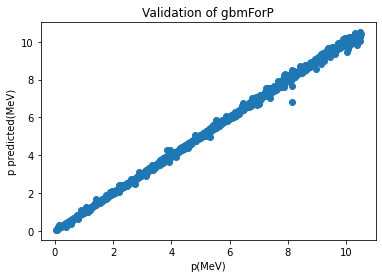

[47017 43381 45564 49792 50729]


In [12]:
plt.scatter(
    p,
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.xlabel("p(MeV)")
plt.ylabel("p predicted(MeV)")
plt.title("Validation of gbmForP")
plt.show()
print(gbmForP.feature_importance())

最后，执行`final.ipynb`，注意要改动一段代码，得到结果。这里只用到了一个训练集，因此效果会差于使用所有训练集训练出的决策树。

这样训练的决策树得到的答案，评测平台给出的分数是0.103。